# Connectionist temporal classification - Word Classification
Implemented in Tensorflow
## TODO
```
Blank labels? Indexs?
Add propper accuracy
Add border to words images
```

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib as plt
import tensorflow as tf
import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.python.layers import core as layers_core
import time
import math
import unidecode

from ocr.datahelpers import loadWordsData, correspondingShuffle, char2idx, sequences_to_sparse
from ocr.helpers import extendImg
from ocr.mlhelpers import TrainingPlot
from ocr.tfhelpers import Graph, create_cell
from ocr.imgtransform import coordinates_remap
from ocr.normalization import imageNorm

%matplotlib notebook
# Increase size of images
plt.rcParams['figure.figsize'] = (9.0, 5.0)

tf.reset_default_graph()
sess = tf.InteractiveSession()
print('Tensorflow', tf.__version__)

Tensorflow 1.4.0


### Loading images

In [2]:
LANG = 'en'

In [3]:
images, labels = loadWordsData(['data/words2/'],
                               loadGaplines=False)

if LANG == 'en':
    for i in range(len(labels)):
        labels[i] = unidecode.unidecode(labels[i])

Loading words...
-> Number of words: 5069


## Settings

In [4]:
char_size = 52
PAD = 0   # Padding

num_new_images = 2                 #  Number of new images per image
fac_alpha = 2.0                    # Factors for image preprocessing
fac_sigma = 0.08

num_buckets = 5
slider_size = (60, 40)
N_INPUT = slider_size[0]*slider_size[1]
vocab_size = char_size + 2         # Number of different chars + <PAD> and <EOS>

layers = 2
residual_layers = 1        # HAVE TO be smaller than layers
units = 256
num_hidden = 2*units


learning_rate = 1e-4               # 1e-4
max_gradient_norm = 5.0            # For gradient clipping
dropout = 0.4
train_per = 0.8                    # Percentage of training data

TRAIN_STEPS = 100000               # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 24
EPOCH = 2000                       # Number of batches in epoch - not accurate
save_location = 'models/word-clas/' + LANG + '/CTC/Classifier'

## Dataset

In [5]:
# Shuffle data for later splitting
images, labels = correspondingShuffle([images, labels])

labels_idx = np.empty(len(labels), dtype=object)
for i, label in enumerate(labels):
    labels_idx[i] = [char2idx(c) for c in label]    # char2idx(c, True)-2

# Split data on train and test dataset
div = int(train_per * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainLabels_idx = labels_idx[0:div]
testLabels_idx = labels_idx[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

Training images: 4055
Testing images: 1014


In [6]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 targets,
                 num_buckets=5,
                 slider=(60, 30),
                 slider_step=2,
                 train=True):
        
        self.train = train
        
        # First PADDING of images to slider size: -(-a // b) ==  ceil(a/b)
        self.slider = slider
        for i in range(len(images)):
            images[i] = extendImg(
                images[i],
                (images[i].shape[0], max(-(-images[i].shape[1] // slider_step) * slider_step, 60)))
        in_length = [(image.shape[1] + 1 - slider[1])//slider_step for image in images]
        
        # Split images to sequence of vectors
        imgseq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            imgseq[i] = [img[:, loc*slider_step: loc*slider_step + slider[1]].flatten()
                         for loc in range(in_length[i])]

        # Create pandas dataFrame and sort it by images width (length) 
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'images': imgseq,
                                       'targets': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")

    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        input_max = max(res['in_length'])
        
        input_seq = np.zeros((batch_size, input_max, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            try:
                input_seq[i][:res['in_length'].values[i]] = img
            except:
                print(i, ":", res['in_length'].values[i])
                print(img)
                
        input_seq = input_seq.swapaxes(0, 1)

        targets = sequences_to_sparse(res['targets'].values)
        
        return input_seq, targets, res['in_length'].values
    
    def next_feed(self, size):
        """ Create feed directly for model training """
        (inputs_,
         targets_,
         inputs_length_) = self.next_batch(size)
        return {
            inputs: inputs_,
            inputs_length: inputs_length_,
            targets: targets_,
            keep_prob: (1.0 - dropout) if self.train else 1.0
        }

In [7]:
# Create iterator for feeding RNN
# Create only once, it modifies: labels_idx
train_iterator = BucketDataIterator(trainImages,
                                    trainLabels_idx,
                                    num_buckets,
                                    slider_size,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testLabels_idx,
                                   num_buckets,
                                   slider_size,
                                   train=False)

Iterator created.
Iterator created.


## Placeholders

In [8]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Inputs - Time major: (max_seq_length, batch_size, vec_size)
inputs = tf.placeholder(shape=(None, None, N_INPUT),
                        dtype=tf.float32,
                        name='inputs')
inputs_length = tf.placeholder(shape=(None,),
                               dtype=tf.int32,
                               name='inputs_length')
# required for training, not required for testing and application
targets = tf.sparse_placeholder(dtype=tf.int32,
                                name='targets')

# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## Graph

In [9]:
enc_cell_fw = create_cell(units,
                          layers,
                          residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)
enc_cell_bw = create_cell(units,
                          layers,
                          residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)

In [10]:
SCALE = 0.01 # 0.1
# Help functions for standard layers
def weights(name, shape):
    return tf.get_variable(name, shape=shape,
                           initializer=tf.contrib.layers.xavier_initializer(),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))

def bias(const, shape, name=None):
    return tf.Variable(tf.constant(const, shape=shape), name=name)

def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


# 1. Layer - Convulation variables
W_conv1 = weights('W_conv1', shape=[5, 5, 1, 4])
b_conv1 = bias(0.1, shape=[4], name='b_conv1')
# 3. Layer - Convulation variables
W_conv2 = weights('W_conv2', shape=[5, 5, 4, 8])
b_conv2 = bias(0.1, shape=[8], name='b_conv2')

def CNN(x):
    x = tf.image.per_image_standardization(x)
    x_imgs = tf.reshape(x, [1, slider_size[0], slider_size[1], 1])
    # 1. Layer - Convulation
    h_conv1 = tf.nn.relu(conv2d(x_imgs, W_conv1) + b_conv1, name='h_conv1')
    # 2. Layer - Max Pool
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    # 3. Layer - Convulation
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')
    # 4. Layer - Max Pool
    return max_pool_2x2(h_conv2, name='h_pool2')

# Input images CNN
processed_inputs = tf.map_fn(
    lambda seq: tf.map_fn(
        lambda img:
            tf.reshape(
                CNN(tf.reshape(img, [slider_size[0], slider_size[1], 1])), [-1]),
        seq),
    inputs,
    dtype=tf.float32)

# Bidirectional RNN, gibe fw and bw outputs separately
bi_outputs, _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = enc_cell_fw,
    cell_bw = enc_cell_bw,
    inputs = processed_inputs,
    sequence_length = inputs_length,
    dtype = tf.float32,
    time_major = True)

con_outputs = tf.concat(bi_outputs, -1)

max_timesteps, batch_size, _ = tf.unstack(tf.shape(inputs))

W = weights('W', shape=[num_hidden, vocab_size])
b = bias(0., shape=[vocab_size], name='b')

outputs = tf.reshape(con_outputs, [-1, num_hidden])
logits = tf.matmul(outputs, W) + b
logits = tf.reshape(logits, [-1, batch_size, vocab_size])

# Or tf.nn.ctc_greedy_decoder (shoudl be faster, but beam_widt=1)
decoded, log_prob = tf.nn.ctc_beam_search_decoder(logits, inputs_length)

word_prediction = tf.sparse_tensor_to_dense(decoded[0], name='word_prediction')

In [11]:
sess.run(tf.global_variables_initializer())
fd  = test_iterator.next_feed(5)
print(word_prediction.eval(fd).shape)

(5, 61)


### Optimizer

In [12]:
ctc_loss = tf.nn.ctc_loss(targets, logits, inputs_length)
regularization = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.identity(tf.reduce_mean(ctc_loss) + sum(regularization), name='loss')

### Optimization
# optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss, name='train_step')

test_targets = tf.sparse_tensor_to_dense(targets)

# TODO CHANGE TO ACCURACY

# It is label error rate not accuracy
accuracy = tf.reduce_mean(
    tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))

#### Accuracy + Padding

In [13]:
# pred_length = decoded[0].get_shape().as_list()[1]
# targets_length = targets.get_shape().as_list()[1]

# pad_lenght = tf.maximum(pred_length, targets_length)

# pred_pad = tf.pad(
#     word_prediction,
#     [[0, 0],
#      [0, pad_lenght - pred_length]],
#     constant_values=PAD,
#     mode='CONSTANT')
# targets_pad = tf.pad(
#     test_targets,
#     [[0, 0],
#      [0, pad_lenght - targets_lenght]],
#     constant_values=PAD,
#     mode='CONSTANT')

# acc_weights = tf.cast(tf.divide(pred_pad, pred_pad), tf.float32)

# # acc_weights = tf.sequence_mask(
# #     tf.subtract(final_seq_lengths, 1),    # word_inputs_length, try max(targets, inputs)
# #     word_pad_lenght,
# #     dtype=tf.float32)

# correct_prediction = tf.equal(pred_pad, targets_pad)
# accuracy = (tf.reduce_sum(tf.cast(correct_prediction, tf.float32) * acc_weights) \
#             / tf.reduce_sum(acc_weights))

## Training

<IPython.core.display.Javascript object>


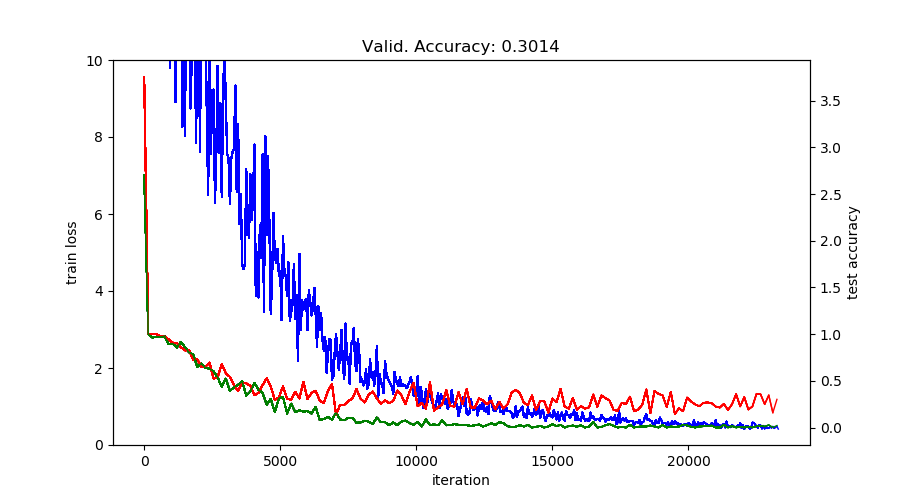

batch 0 - loss: 103.91685
    expected  > [11 44 27 46 37 51  0]
    predicted > [50 44 50 44 47 44 47 44 47 44 47 44 47 44 50 44]
    expected  > [41 44  0  0  0  0  0]
    predicted > [50 44 47 44 50 44 50 44 50 44 50 44  6 44  0  0]

batch 2000 - loss: 8.4976997
    expected  > [30 27 30  0  0  0]
    predicted > [30  0  0]
    expected  > [25 47 39  0  0  0]
    predicted > [25  0  0]

batch 4000 - loss: 6.7339072
    expected  > [40 51 40 35  0  0  0]
    predicted > [40 51 40 35  0]
    expected  > [18 31 34 41 44  0  0]
    predicted > [ 1 37  0  0  0]

batch 6000 - loss: 5.5539308
    expected  > [18 27 35 30  0  0  0  0]
    predicted > [18 27 35 30  0  0  0]
    expected  > [44 35 30 35  0  0  0  0]
    predicted > [44 35 30 35  0  0  0]

batch 8000 - loss: 6.5313263
    expected  > [22 44 45 46 48 27  0  0  0  0  0]
    predicted > [22 40 45 46 48 27  0  0  0  0  0  0]
    expected  > [41 49 40  0  0  0  0  0  0  0  0]
    predicted > [41 40 49 41  0  0  0  0  0  0  0  0]

b

In [14]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_location)
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
            predict_, target_ = sess.run([word_prediction, test_targets], fd_test)
            for i, (inp, pred) in enumerate(zip(target_, predict_)):
                print('    expected  > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 1:
                    break
            print()

except KeyboardInterrupt:
    saver.save(sess, save_location)
    print('Training interrupted, model saved.')

In [15]:
for i in range(5):
    fd_test = test_iterator.next_feed(BATCH_SIZE)
    predict_, target_ = sess.run([word_prediction, test_targets], fd_test)
    for i, (inp, pred) in enumerate(zip(target_, predict_)):
        print('    expected  > {}'.format(inp))
        print('    predicted > {}'.format(pred))
        if i >= 1:
            break
    print()

    expected  > [28 27 34 40 41  0  0  0  0  0  0]
    predicted > [28 27 38 40 41  0  0  0  0  0]
    expected  > [42 27 47 45 31  0  0  0  0  0  0]
    predicted > [42 41 44 41 44 38  0  0  0  0]

    expected  > [32 35 33 34 46  0]
    predicted > [32 35 33 34 46  0]
    expected  > [48 51 48 41 36  0]
    predicted > [48 51 41  0  0  0]

    expected  > [ 2 31 38 35 31 48 31  0  0  0  0]
    predicted > [ 2 31 38 35 31 48 31  0  0  0  0  0]
    expected  > [31 39 42 35 44 35 29 37 51 39 35]
    predicted > [39 42 35 44 35 29 37 51 39 35  0  0]

    expected  > [37 31 51  0  0]
    predicted > [37 47 51  0]
    expected  > [21  0  0  0  0]
    predicted > [21  0  0  0]

    expected  > [41 37 41 38 35  0  0]
    predicted > [41 37 41 38 35  0  0  0]
    expected  > [ 9 40 40 31 44  0  0]
    predicted > [ 9 40 31 44  0  0  0  0]

